In [1]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord
from inverse_covariance import QuicGraphicalLasso

# utils
import sys
sys.path.append('../utils')
from utils import partial_corr, compute_tp_fp, mcc, precision_recall, pseudo_BIC, gauss_BIC, proj_precision_mat
from generate_graphs import generate_erdos_renyi, generate_data

### Hub Network

In [2]:
Skel = np.genfromtxt('../data/hub-network-structure.txt', delimiter=',')

n, p = 500, 1000
n_prop_to_p = [0.5]
random_state = 2023
lower_weight, upper_weight = 0.5, 1.0
spread_diag=[1, np.sqrt(3)]

# projection method
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Theta = np.multiply(edge_weights, edge_signs)
Theta = np.multiply(Skel, Theta)
Theta = np.tril(Theta) + np.tril(Theta).T
nz_indx = np.nonzero(Theta)
for i in range(100):
    Theta = proj_precision_mat(Theta, nz_indx)
    if np.linalg.cond(Theta) < 20:
        break

Theta = np.real(Theta)
Partial_corr = partial_corr(Theta)
Sigma = np.linalg.inv(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

In [5]:
from nitk import methods
from nitk.space import *
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
import rpy2.rinterface as rinterface

rpy2.robjects.numpy2ri.activate()
space = importr('space')
l = 0.5
prec = space.space_joint(X, np.array([l]))
prec = np.array(prec[0])

[1] "iter=1"
[1] "iter=2"


### Erdos-Renyi

In [2]:
n, p = 500, 1000
n_prop_to_p = [0.5]
Theta, Sigma = generate_erdos_renyi(p, n_prop_to_p, type='proj', edge_prob=0.01, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, np.sqrt(3)], random_state=2023)
Partial_corr = partial_corr(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

### Cross-Validation

In [3]:
# search for lambda
S = np.matmul(X.T, X)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
lams

array([0.0369684 , 0.04002335, 0.04333075, 0.04691146, 0.05078807,
       0.05498503, 0.05952881, 0.06444808, 0.06977386, 0.07553974,
       0.0817821 , 0.08854031, 0.09585699, 0.1037783 , 0.1123542 ,
       0.12163878, 0.13169061, 0.14257309, 0.15435487, 0.16711025,
       0.1809197 , 0.19587031, 0.21205639, 0.22958004, 0.24855179,
       0.26909129, 0.29132812, 0.31540252, 0.34146636, 0.36968402])

### Model Selection Comparison

In [4]:
# lams = lams[::-1][14:26] # pre-selected lambdas for hub-network (n=500, p=1000)
lams = lams[::-1][7:19] # pre-selected lambdas for erdos-renyi (n=500, p=1000)

accord_precs, accord_recalls, accord_mccs = [], [], []
concord_precs, concord_recalls, concord_mccs = [], [], []
glasso_precs, glasso_recalls, glasso_mccs = [], [], []

p_bics, ep_bics_01, ep_bics_02, gauss_bics = [], [], [], []

for lam in lams:
    print(lam)

    # accord
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, stepsize_multiplier=2.0, backtracking=True, epstol=1e-5, maxitr=500, penalize_diag=True)
    model.fit(X)
    Omega_hat = model.omega_.toarray()
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))

    p_bics.append(pseudo_BIC(X, Omega_hat, Theta_hat, type='theta', modified=False))
    ep_bics_01.append(pseudo_BIC(X, Omega_hat, Theta_hat, type='theta', modified=True, gamma=0.1))
    ep_bics_02.append(pseudo_BIC(X, Omega_hat, Theta_hat, type='theta', modified=True, gamma=0.2))
    gauss_bics.append(gauss_BIC(X, Omega_hat, Theta_hat, type='theta'))

    prec, recall = precision_recall(Theta, Theta_hat)
    accord_precs.append(prec)
    accord_recalls.append(recall)
    accord_mccs.append(mcc(Theta, Theta_hat))

    # concord
    model = GraphicalConcord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, constant_stepsize=0.0, backtracking=True, epstol=1e-5, maxitr=500, penalize_diag=True)
    model.fit(X)
    Theta_hat = model.omega_.toarray()

    prec, recall = precision_recall(Theta, Theta_hat)
    concord_precs.append(prec)
    concord_recalls.append(recall)
    concord_mccs.append(mcc(Theta, Theta_hat))

    # glasso
    quic = QuicGraphicalLasso(lam=lam).fit(X)
    Theta_hat = quic.precision_

    prec, recall = precision_recall(Theta, Theta_hat)
    glasso_precs.append(prec)
    glasso_recalls.append(recall)
    glasso_mccs.append(mcc(Theta, Theta_hat))

0.2120563931663295
0.19587031044800898
0.18091969754907192
0.1671102521172339
0.15435486981792568
0.14257309491577078
0.1316906127927086
0.12163878120177332
0.11235419729987087
0.10377829772857246


In [47]:
# np.savetxt('data/hub_network_accord_precs.txt', accord_precs, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_accord_recalls.txt', accord_recalls, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_accord_mccs.txt', accord_mccs, fmt='%s', delimiter=',')

# np.savetxt('data/hub_network_concord_precs.txt', concord_precs, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_concord_recalls.txt', concord_recalls, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_concord_mccs.txt', concord_mccs, fmt='%s', delimiter=',')

# np.savetxt('data/hub_network_glasso_precs.txt', glasso_precs, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_glasso_recalls.txt', glasso_recalls, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_glasso_mccs.txt', glasso_mccs, fmt='%s', delimiter=',')

# np.savetxt('data/hub_network_p_bics.txt', p_bics, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_ep_bics_01.txt', ep_bics_01, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_ep_bics_02.txt', ep_bics_02, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_gauss_bics.txt', gauss_bics, fmt='%s', delimiter=',')

In [ ]:
np.savetxt('data/erdos_renyi_accord_precs.txt', accord_precs, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_accord_recalls.txt', accord_recalls, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_accord_mccs.txt', accord_mccs, fmt='%s', delimiter=',')

np.savetxt('data/erdos_renyi_concord_precs.txt', concord_precs, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_concord_recalls.txt', concord_recalls, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_concord_mccs.txt', concord_mccs, fmt='%s', delimiter=',')

np.savetxt('data/erdos_renyi_glasso_precs.txt', glasso_precs, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_glasso_recalls.txt', glasso_recalls, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_glasso_mccs.txt', glasso_mccs, fmt='%s', delimiter=',')

np.savetxt('data/erdos_renyi_p_bics.txt', p_bics, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_ep_bics_01.txt', ep_bics_01, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_ep_bics_02.txt', ep_bics_02, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_gauss_bics.txt', gauss_bics, fmt='%s', delimiter=',')

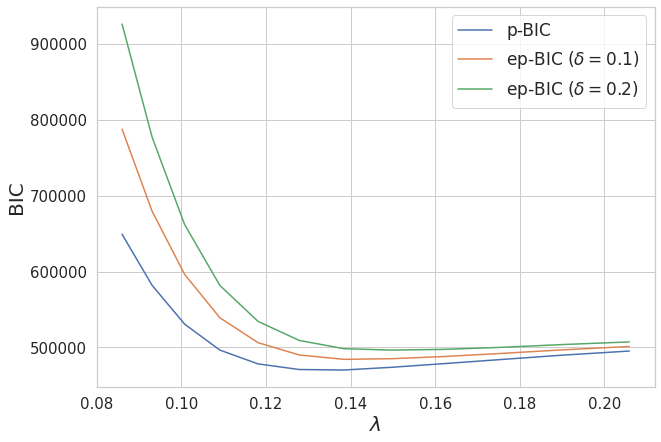

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(lams, p_bics, label='p-BIC')
plt.plot(lams, ep_bics_01, label='ep-BIC ($\delta=0.1$)')
plt.plot(lams, ep_bics_02, label='ep-BIC ($\delta=0.2$)')
# plt.plot(lams, accord_gauss_bics, label='gauss-BIC')
plt.xlabel('$\lambda$', fontsize=20)
plt.ylabel('BIC', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17);

plt.savefig('../output/pseudo-bic-plot-erdos-renyi.png', bbox_inches='tight');

In [ ]:
best_p_bic = np.argmin(p_bics)
best_ep_bic_02 = np.argmin(ep_bics_02)
best_gauss_bic = np.argmin(gauss_bics)

### Visualization (hub-network)

In [51]:
# load hub network results
p_bics = np.genfromtxt('data/hub_network_p_bics.txt', delimiter=',')
ep_bics_02 = np.genfromtxt('data/hub_network_ep_bics_02.txt', delimiter=',')
gauss_bics = np.genfromtxt('data/hub_network_gauss_bics.txt', delimiter=',')
best_p_bic = np.argmin(p_bics)
best_ep_bic_02 = np.argmin(ep_bics_02)
best_gauss_bic = np.argmin(gauss_bics)

accord_mccs = np.genfromtxt('data/hub_network_accord_mccs.txt', delimiter=',')
accord_precs = np.genfromtxt('data/hub_network_accord_precs.txt', delimiter=',')
accord_recalls = np.genfromtxt('data/hub_network_accord_recalls.txt', delimiter=',')
concord_mccs = np.genfromtxt('data/hub_network_concord_mccs.txt', delimiter=',')
concord_precs = np.genfromtxt('data/hub_network_concord_precs.txt', delimiter=',')
concord_recalls = np.genfromtxt('data/hub_network_concord_recalls.txt', delimiter=',')
glasso_mccs = np.genfromtxt('data/hub_network_glasso_mccs.txt', delimiter=',')
glasso_precs = np.genfromtxt('data/hub_network_glasso_precs.txt', delimiter=',')
glasso_recalls = np.genfromtxt('data/hub_network_glasso_recalls.txt', delimiter=',')

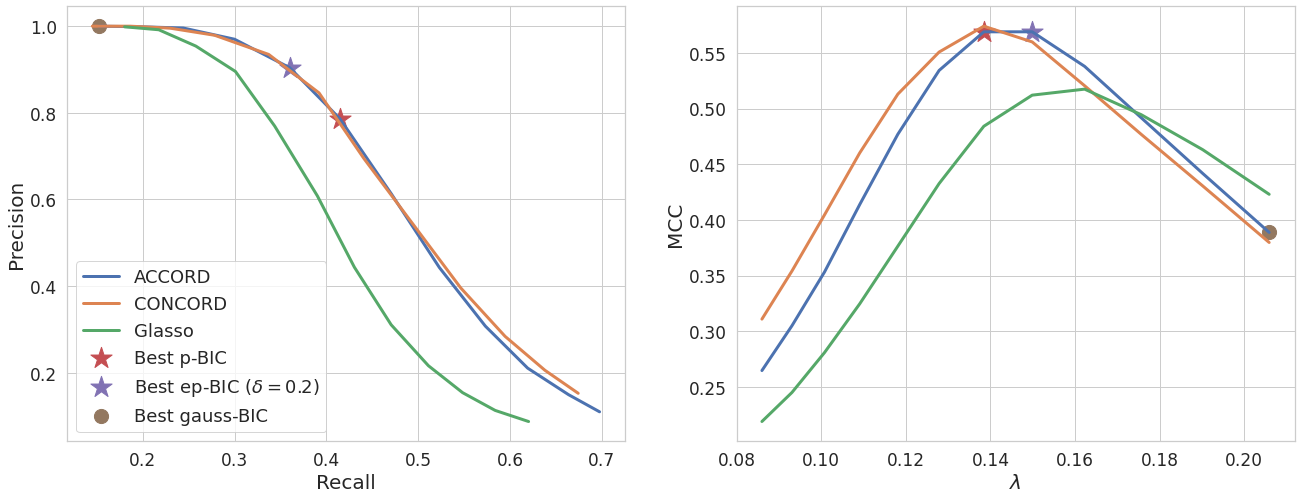

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(accord_recalls, accord_precs, linewidth=3, label='ACCORD')
axes[i].plot(concord_recalls, concord_precs, linewidth=3, label='CONCORD')
axes[i].plot(glasso_recalls, glasso_precs, linewidth=3, label='Glasso')
axes[i].scatter(accord_recalls[best_p_bic], accord_precs[best_p_bic], marker='*', s=500, color=sns.color_palette()[3], label='Best p-BIC')
axes[i].scatter(accord_recalls[best_ep_bic_02], accord_precs[best_ep_bic_02], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC ($\delta = 0.2$)')
axes[i].scatter(accord_recalls[best_gauss_bic], accord_precs[best_gauss_bic], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')
axes[i].set_xlabel('Recall', fontsize=20)
axes[i].set_ylabel('Precision', fontsize=20)
# axes[i].set_xlim((0.15,0.45))
# axes[i].set_ylim((0.9,1.01))
axes[i].tick_params(axis='both', which='major', labelsize=17)
axes[i].legend(fontsize=18)

i = 1
axes[i].plot(lams, accord_mccs, linewidth=3, label='ACCORD')
axes[i].plot(lams, concord_mccs, linewidth=3, label='CONCORD')
axes[i].plot(lams, glasso_mccs, linewidth=3, label='Glasso')
axes[i].scatter(lams[best_p_bic], accord_mccs[best_p_bic], marker='*', s=500, color=sns.color_palette()[3], label='Best p-BIC')
axes[i].scatter(lams[best_ep_bic_02], accord_mccs[best_ep_bic_02], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC ($\delta = 0.2$)')
axes[i].scatter(lams[best_gauss_bic], accord_mccs[best_gauss_bic], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')
axes[i].set_xlabel('$\lambda$', fontsize=20)
axes[i].set_ylabel('MCC', fontsize=20)
# axes[i].set_ylim((0.35,0.59))

axes[i].tick_params(axis='both', which='major', labelsize=17)

# plt.savefig('../output/precision-recall-hub-network.png', bbox_inches='tight');

### Visualization (Erdos-Renyi)

In [ ]:
# load erdos renyi results
p_bics = np.genfromtxt('data/erdos_renyi_p_bics.txt', delimiter=',')
ep_bics_02 = np.genfromtxt('data/erdos_renyi_ep_bics_02.txt', delimiter=',')
gauss_bics = np.genfromtxt('data/erdos_renyi_gauss_bics.txt', delimiter=',')
best_p_bic = np.argmin(p_bics)
best_ep_bic_02 = np.argmin(ep_bics_02)
best_gauss_bic = np.argmin(gauss_bics)

accord_mccs = np.genfromtxt('data/erdos_renyi_accord_mccs.txt', delimiter=',')
accord_precs = np.genfromtxt('data/erdos_renyi_accord_precs.txt', delimiter=',')
accord_recalls = np.genfromtxt('data/erdos_renyi_accord_recalls.txt', delimiter=',')
concord_mccs = np.genfromtxt('data/erdos_renyi_concord_mccs.txt', delimiter=',')
concord_precs = np.genfromtxt('data/erdos_renyi_concord_precs.txt', delimiter=',')
concord_recalls = np.genfromtxt('data/erdos_renyi_concord_recalls.txt', delimiter=',')
glasso_mccs = np.genfromtxt('data/erdos_renyi_glasso_mccs.txt', delimiter=',')
glasso_precs = np.genfromtxt('data/erdos_renyi_glasso_precs.txt', delimiter=',')
glasso_recalls = np.genfromtxt('data/erdos_renyi_glasso_recalls.txt', delimiter=',')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(accord_recalls, accord_precs, linewidth=3, label='ACCORD')
axes[i].plot(concord_recalls, concord_precs, linewidth=3, label='CONCORD')
axes[i].plot(glasso_recalls, glasso_precs, linewidth=3, label='Glasso')
axes[i].scatter(accord_recalls[best_p_bic], accord_precs[best_p_bic], marker='*', s=500, color=sns.color_palette()[3], label='Best p-BIC')
axes[i].scatter(accord_recalls[best_ep_bic_02], accord_precs[best_ep_bic_02], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC ($\delta = 0.2$)')
axes[i].scatter(accord_recalls[best_gauss_bic], accord_precs[best_gauss_bic], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')
axes[i].set_xlabel('Recall', fontsize=20)
axes[i].set_ylabel('Precision', fontsize=20)
axes[i].tick_params(axis='both', which='major', labelsize=17)
axes[i].legend(fontsize=18)

i = 1
axes[i].plot(lams, accord_mccs, linewidth=3, label='ACCORD')
axes[i].plot(lams, concord_mccs, linewidth=3, label='CONCORD')
axes[i].plot(lams, glasso_mccs, linewidth=3, label='Glasso')
axes[i].scatter(lams[best_p_bic], accord_mccs[best_p_bic], marker='*', s=500, color=sns.color_palette()[3], label='Best p-BIC')
axes[i].scatter(lams[best_ep_bic_02], accord_mccs[best_ep_bic_02], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC ($\delta = 0.2$)')
axes[i].scatter(lams[best_gauss_bic], accord_mccs[best_gauss_bic], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')
axes[i].set_xlabel('$\lambda$', fontsize=20)
axes[i].set_ylabel('MCC', fontsize=20)

axes[i].tick_params(axis='both', which='major', labelsize=17)

# plt.savefig('../output/precision-recall-erdos_renyi.png', bbox_inches='tight');

In [4]:
lams = lams[::-1][17:29] # pre-selected lambdas for hub-network (n=500, p=1000)
# lams = lams[::-1][9:21] # pre-selected lambdas for erdos-renyi (n=500, p=1000)

# lams = lams[::-1][19:] # pre-selected lambdas for hub-network (n=1000, p=1000)
# lams = lams[::-1][12:24] # pre-selected lambdas for erdos-renyi (n=1000, p=1000)

p_bics_theta = []
ep_bics_01_theta = []
ep_bics_02_theta = []
ep_bics_03_theta = []
gauss_bics_theta = []

p_bics_edge = []
ep_bics_01_edge = []
ep_bics_02_edge = []
ep_bics_03_edge = []
gauss_bics_edge = []

p_bics_omega = []
ep_bics_01_omega = []
ep_bics_02_omega = []
ep_bics_03_omega = []
gauss_bics_omega = []

precs, recalls, mccs = [], [], []

for lam in lams:
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, stepsize_multiplier=2.0, backtracking=True, epstol=1e-5, maxitr=500, penalize_diag=True)
    model.fit(X)
    Omega_hat = model.omega_.toarray()
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))

    type = 'theta'
    p_bic_theta = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=False)
    p_bics_theta.append(p_bic_theta)
    ep_bic_01_theta = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=True, gamma=0.1)
    ep_bics_01_theta.append(ep_bic_01_theta)
    ep_bic_02_theta = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=True, gamma=0.2)
    ep_bics_02_theta.append(ep_bic_02_theta)
    ep_bic_03_theta = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=True, gamma=0.3)
    ep_bics_03_theta.append(ep_bic_03_theta)
    gauss_bic_theta = gauss_BIC(X, Omega_hat, Theta_hat, type)
    gauss_bics_theta.append(gauss_bic_theta)

    type = 'edge'
    p_bic_edge = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=False)
    p_bics_edge.append(p_bic_edge)
    ep_bic_01_edge = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=True, gamma=0.1)
    ep_bics_01_edge.append(ep_bic_01_edge)
    ep_bic_02_edge = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=True, gamma=0.2)
    ep_bics_02_edge.append(ep_bic_02_edge)
    ep_bic_03_edge = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=True, gamma=0.3)
    ep_bics_03_edge.append(ep_bic_03_edge)
    gauss_bic_edge = gauss_BIC(X, Omega_hat, Theta_hat, type)
    gauss_bics_edge.append(gauss_bic_edge)

    type = 'omega'
    p_bic_omega = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=False)
    p_bics_omega.append(p_bic_omega)
    ep_bic_01_omega = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=True, gamma=0.1)
    ep_bics_01_omega.append(ep_bic_01_omega)
    ep_bic_02_omega = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=True, gamma=0.2)
    ep_bics_02_omega.append(ep_bic_02_omega)
    ep_bic_03_omega = pseudo_BIC(X, Omega_hat, Theta_hat, type, modified=True, gamma=0.3)
    ep_bics_03_omega.append(ep_bic_03_omega)
    gauss_bic_omega = gauss_BIC(X, Omega_hat, Theta_hat, type)
    gauss_bics_omega.append(gauss_bic_omega)

    tp, fp = compute_tp_fp(Theta, Theta_hat)
    prec, recall = precision_recall(Theta, Theta_hat)
    precs.append(prec)
    recalls.append(recall)
    mccs.append(mcc(Theta, Theta_hat))

    print('lam:', np.round(lam, 4), ', # of nonzero:', len(np.flatnonzero(Theta_hat)), ', TP:', tp, ', FP:', fp,\
           ', MCC:', np.round(mcc(Theta, Theta_hat),3),\
           'Precision:', np.round(prec,3),\
           'Recall:', np.round(recall,3))
    
best_p_bic_theta = np.argmin(p_bics_theta)
best_ep_bic_01_theta = np.argmin(ep_bics_01_theta)
best_ep_bic_02_theta = np.argmin(ep_bics_02_theta)
best_ep_bic_03_theta = np.argmin(ep_bics_03_theta)
best_gauss_bic_theta = np.argmin(gauss_bics_theta)

best_p_bic_edge = np.argmin(p_bics_edge)
best_ep_bic_01_edge = np.argmin(ep_bics_01_edge)
best_ep_bic_02_edge = np.argmin(ep_bics_02_edge)
best_ep_bic_03_edge = np.argmin(ep_bics_03_edge)
best_gauss_bic_edge = np.argmin(gauss_bics_edge)

best_p_bic_omega = np.argmin(p_bics_omega)
best_ep_bic_01_omega = np.argmin(ep_bics_01_omega)
best_ep_bic_02_omega = np.argmin(ep_bics_02_omega)
best_ep_bic_03_omega = np.argmin(ep_bics_03_omega)
best_gauss_bic_omega = np.argmin(gauss_bics_omega)

lam: 0.2595 , # of nonzero: 2764 , TP: 1764 , FP: 0 , MCC: 0.423 Precision: 1.0 Recall: 0.18
lam: 0.2397 , # of nonzero: 3750 , TP: 2748 , FP: 2 , MCC: 0.528 Precision: 0.999 Recall: 0.281
lam: 0.2214 , # of nonzero: 4744 , TP: 3738 , FP: 6 , MCC: 0.615 Precision: 0.998 Recall: 0.382
lam: 0.2045 , # of nonzero: 5776 , TP: 4734 , FP: 42 , MCC: 0.69 Precision: 0.991 Recall: 0.483
lam: 0.1889 , # of nonzero: 6848 , TP: 5676 , FP: 172 , MCC: 0.748 Precision: 0.971 Recall: 0.58
lam: 0.1745 , # of nonzero: 8002 , TP: 6462 , FP: 540 , MCC: 0.779 Precision: 0.923 Recall: 0.66
lam: 0.1612 , # of nonzero: 9562 , TP: 7176 , FP: 1386 , MCC: 0.782 Precision: 0.838 Recall: 0.733
lam: 0.1489 , # of nonzero: 11814 , TP: 7726 , FP: 3088 , MCC: 0.748 Precision: 0.714 Recall: 0.789
lam: 0.1375 , # of nonzero: 15522 , TP: 8242 , FP: 6280 , MCC: 0.688 Precision: 0.568 Recall: 0.842
lam: 0.127 , # of nonzero: 21254 , TP: 8594 , FP: 11660 , MCC: 0.605 Precision: 0.424 Recall: 0.877
lam: 0.1173 , # of nonzero

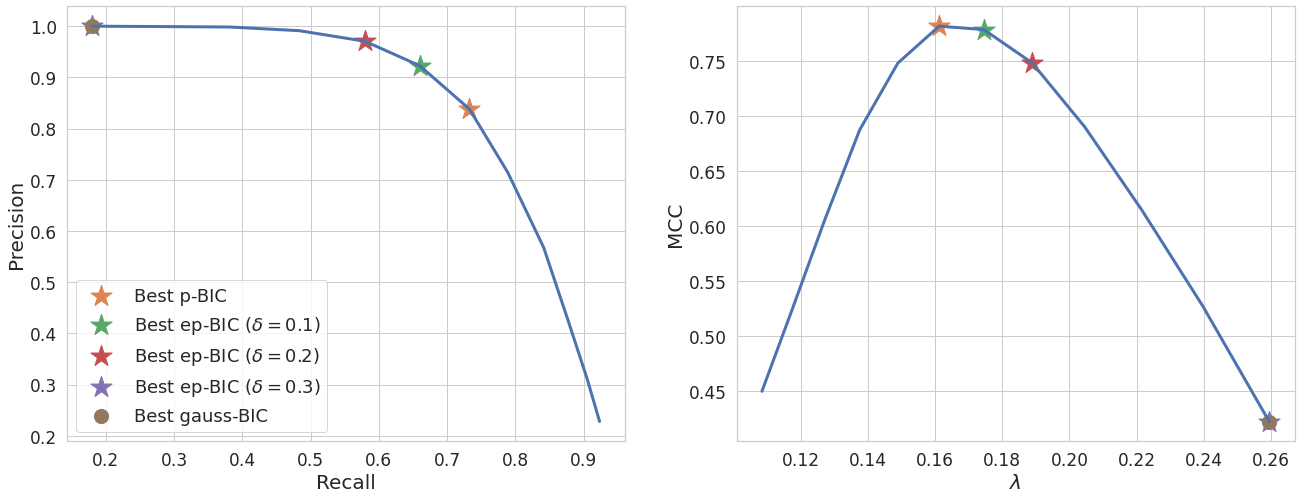

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(recalls, precs, linewidth=3)
axes[i].scatter(recalls[best_p_bic_theta], precs[best_p_bic_theta], marker='*', s=500, color=sns.color_palette()[1], label='Best p-BIC')
axes[i].scatter(recalls[best_ep_bic_01_theta], precs[best_ep_bic_01_theta], marker='*', s=500, color=sns.color_palette()[2], label='Best ep-BIC ($\delta = 0.1$)')
axes[i].scatter(recalls[best_ep_bic_02_theta], precs[best_ep_bic_02_theta], marker='*', s=500, color=sns.color_palette()[3], label='Best ep-BIC ($\delta = 0.2$)')
axes[i].scatter(recalls[best_ep_bic_03_theta], precs[best_ep_bic_03_theta], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC ($\delta = 0.3$)')
axes[i].scatter(recalls[best_gauss_bic_theta], precs[best_gauss_bic_theta], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')
axes[i].set_xlabel('Recall', fontsize=20)
axes[i].set_ylabel('Precision', fontsize=20)
axes[i].tick_params(axis='both', which='major', labelsize=17)
axes[i].legend(fontsize=18)

i = 1
axes[i].plot(lams, mccs, linewidth=3)
axes[i].scatter(lams[best_p_bic_theta], mccs[best_p_bic_theta], marker='*', s=500, color=sns.color_palette()[1], label='Best p-BIC')
axes[i].scatter(lams[best_ep_bic_01_theta], mccs[best_ep_bic_01_theta], marker='*', s=500, color=sns.color_palette()[2], label='Best ep-BIC ($\delta = 0.1$)')
axes[i].scatter(lams[best_ep_bic_02_theta], mccs[best_ep_bic_02_theta], marker='*', s=500, color=sns.color_palette()[3], label='Best ep-BIC ($\delta = 0.2$)')
axes[i].scatter(lams[best_ep_bic_03_theta], mccs[best_ep_bic_03_theta], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC ($\delta = 0.3$)')
axes[i].scatter(lams[best_gauss_bic_theta], mccs[best_gauss_bic_theta], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')

axes[i].set_xlabel('$\lambda$', fontsize=20)
axes[i].set_ylabel('MCC', fontsize=20)

axes[i].tick_params(axis='both', which='major', labelsize=17)

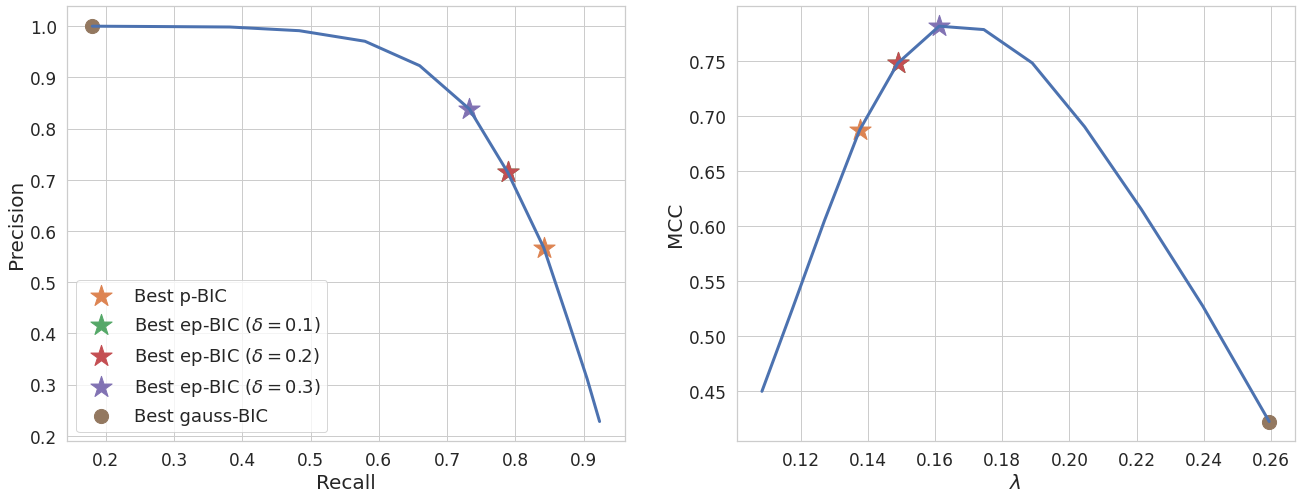

In [6]:
# hub n = 0.5p

fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(recalls, precs, linewidth=3)
axes[i].scatter(recalls[best_p_bic_edge], precs[best_p_bic_edge], marker='*', s=500, color=sns.color_palette()[1], label='Best p-BIC')
axes[i].scatter(recalls[best_ep_bic_01_edge], precs[best_ep_bic_01_edge], marker='*', s=500, color=sns.color_palette()[2], label='Best ep-BIC ($\delta = 0.1$)')
axes[i].scatter(recalls[best_ep_bic_02_edge], precs[best_ep_bic_02_edge], marker='*', s=500, color=sns.color_palette()[3], label='Best ep-BIC ($\delta = 0.2$)')
axes[i].scatter(recalls[best_ep_bic_03_edge], precs[best_ep_bic_03_edge], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC ($\delta = 0.3$)')
axes[i].scatter(recalls[best_gauss_bic_edge], precs[best_gauss_bic_edge], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')
axes[i].set_xlabel('Recall', fontsize=20)
axes[i].set_ylabel('Precision', fontsize=20)
axes[i].tick_params(axis='both', which='major', labelsize=17)
axes[i].legend(fontsize=18)

i = 1
axes[i].plot(lams, mccs, linewidth=3)
axes[i].scatter(lams[best_p_bic_edge], mccs[best_p_bic_edge], marker='*', s=500, color=sns.color_palette()[1], label='Best p-BIC')
axes[i].scatter(lams[best_ep_bic_01_edge], mccs[best_ep_bic_01_edge], marker='*', s=500, color=sns.color_palette()[2], label='Best ep-BIC ($\delta = 0.1$)')
axes[i].scatter(lams[best_ep_bic_02_edge], mccs[best_ep_bic_02_edge], marker='*', s=500, color=sns.color_palette()[3], label='Best ep-BIC ($\delta = 0.2$)')
axes[i].scatter(lams[best_ep_bic_03_edge], mccs[best_ep_bic_03_edge], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC ($\delta = 0.3$)')
axes[i].scatter(lams[best_gauss_bic_edge], mccs[best_gauss_bic_edge], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')

axes[i].set_xlabel('$\lambda$', fontsize=20)
axes[i].set_ylabel('MCC', fontsize=20)

axes[i].tick_params(axis='both', which='major', labelsize=17)

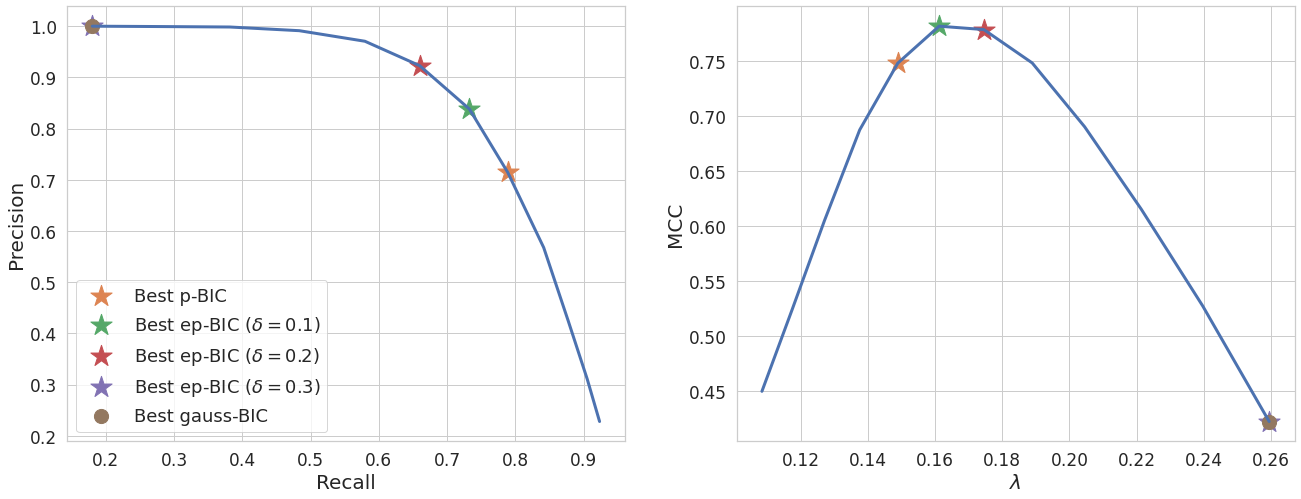

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(recalls, precs, linewidth=3)
axes[i].scatter(recalls[best_p_bic_omega], precs[best_p_bic_omega], marker='*', s=500, color=sns.color_palette()[1], label='Best p-BIC')
axes[i].scatter(recalls[best_ep_bic_01_omega], precs[best_ep_bic_01_omega], marker='*', s=500, color=sns.color_palette()[2], label='Best ep-BIC ($\delta = 0.1$)')
axes[i].scatter(recalls[best_ep_bic_02_omega], precs[best_ep_bic_02_omega], marker='*', s=500, color=sns.color_palette()[3], label='Best ep-BIC ($\delta = 0.2$)')
axes[i].scatter(recalls[best_ep_bic_03_omega], precs[best_ep_bic_03_omega], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC ($\delta = 0.3$)')
axes[i].scatter(recalls[best_gauss_bic_omega], precs[best_gauss_bic_omega], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')
axes[i].set_xlabel('Recall', fontsize=20)
axes[i].set_ylabel('Precision', fontsize=20)
axes[i].tick_params(axis='both', which='major', labelsize=17)
axes[i].legend(fontsize=18)

i = 1
axes[i].plot(lams, mccs, linewidth=3)
axes[i].scatter(lams[best_p_bic_omega], mccs[best_p_bic_omega], marker='*', s=500, color=sns.color_palette()[1], label='Best p-BIC')
axes[i].scatter(lams[best_ep_bic_01_omega], mccs[best_ep_bic_01_omega], marker='*', s=500, color=sns.color_palette()[2], label='Best ep-BIC ($\delta = 0.1$)')
axes[i].scatter(lams[best_ep_bic_02_omega], mccs[best_ep_bic_02_omega], marker='*', s=500, color=sns.color_palette()[3], label='Best ep-BIC ($\delta = 0.2$)')
axes[i].scatter(lams[best_ep_bic_03_omega], mccs[best_ep_bic_03_omega], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC ($\delta = 0.3$)')
axes[i].scatter(lams[best_gauss_bic_omega], mccs[best_gauss_bic_omega], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')

axes[i].set_xlabel('$\lambda$', fontsize=20)
axes[i].set_ylabel('MCC', fontsize=20)

axes[i].tick_params(axis='both', which='major', labelsize=17)